# 1 Importing python packages

In [443]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import missingno as msno
import re
from pathlib import Path
from matplotlib.figure import Figure
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('png')


# 2 Exploratory Data Analysis (EDA)

source of data: https://www.kaggle.com/datasets/ychope/loan-approval-dataset/data

## 2.1 Feature Glossary

**Loan & Application Characteristics**
- loan_limit: Indicates whether the loan amount falls within conforming loan limits or exceeds regulatory thresholds
- approv_in_adv: Whether the Loan has been approved in advance, before formal application submission
- loan_type: Type of loan 
- loan_purpose: Purpose of Loan e.g. home purchase, refinancing
- submission_of_application: The channel through which the loan application was submitted (e.g., online, broker, branch)
- year: Calendar year when the loan was accepted or rejected

**Applicant's profile**
- Unnamed: 0 : Anonimized applicant's name
- id: Loan applicant ID
- gender: Gender of loan applicant
- age: Age category of the applicant
- income: Annual income of loan applicant
- senior_age: Indicates whether the applicant falls into a senior age group
- region: Geographic region of loan applicant

**Credit History**
- credit_worthiness: Categorical assessment of the applicant’s overall credit risk profile
- open_credit: Indicates whether the applicant has open lines of credit at the time of application
- co-applicant_credit_type: Credit history classification of the co-applicant, if present
- credit_type: Type of credit history or bureau record associated with the applicant
- credit_score: Applicant's credit score, summarizing the applicant’s creditworthiness


**Loan & Payment Structure**
- loan_amount: Loan amount
- rate_of_interest: Loan interest rate (If approved. NaN if the loan is not approved)
- interest_rate_spread: Difference between the loan’s interest rate and a benchmark reference rate
- term: Duration of the loan repayment period, measured in months
- neg_ammortization: Indicator of whether the loan allows negative amortization
- interest_only: Specifies whether the loan permits interest-only payments for an initial period
- lump_sum_payment: Indicates whether a lump-sum or balloon payment is required at maturity
- high_interest_rate: Flag identifying loans with interest rates above a predefined threshold

**Fees**
- upfront_charges: Fees charged at loan origination, including processing or administrative costs

**Property & Collateral Information**
- property_value: Appraised or estimated value of the collateral property
- ltv: Ratio of the loan amount to the property value, a key risk metric
- construction_type: Classification of the property’s construction 
- occupancy_type: Indicates whether the property is owner-occupied, rented, or secondary residence
- secured_by: Type of asset used to secure the loan
- security_type: Classification of the collateral or lien structure securing the loan
- total_units: Number of residential units associated with the property

**Business & Usage**
- business_or_commercial: Business loan or commercial loan

**Debt &Affordability Indicators**
- dtir1: Ratio of total debt obligations to income

**Target Variable**
- status: Loan outcome indicating approval or rejection

## 2.2 Checking the basic info of the data

check: info, shape, variable types and description

In [818]:
# loading dataset into pandas dataframe
# set header to 0 to keep feature names
# set header to 1 to drop feature names
df_loan = pd.read_csv("data\\Loan.csv", delimiter=",", header=0)

# set common path to save figures
fig_dir = Path("figures/eda")
fig_dir.mkdir(parents=True, exist_ok=True)

In [819]:
# use .svg format to draw sophisticated plots
# reminder: set dpi to 300 as .md file may not render it
def save_fig(fig: Figure, fig_dir: Path, fig_name: str, ext: str, dpi: int)-> None:
    fig_name = fig_name.strip().lower()
    fig_name = re.sub(r"\s+", "_", fig_name)
    fig.savefig(f"{fig_dir}/{fig_name}.{ext}", bbox_inches="tight", dpi=dpi)

In [820]:
#print(df_loan.columns)

In [821]:
# type((df_loan.shape)) is a tuple

n_rows, n_cols = df_loan.shape
data_dimensionality = {"Dimension": ["Rows", "Columns"], "Count": [n_rows, n_cols]}
# transform dictionary into a DataFrame object
df_dimensionality = pd.DataFrame(data_dimensionality)

# explicitly create fig
fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    data=df_dimensionality,
    x="Dimension",
    y="Count",
    palette="crest",
    hue="Dimension",
    dodge=False,
    legend=False,
    width=0.4,
    ax=ax,
)
for container in ax.containers:
    ax.bar_label(container, padding=1.0, fontsize=10)

ax.set_xlabel(df_dimensionality.columns[0], fontweight="bold")
ax.set_ylabel(df_dimensionality.columns[1], fontweight="bold")
ax.margins(y=0.1)

# I use ax.set_title() because it's aligned more precisely to the center of the subplots if there is only a single subplot
ax.set_title("Loan Dataset Dimensionality", fontsize=16, fontweight="bold", y=1.05)

fig_name = ax.get_title()
save_fig(fig, fig_dir, fig_name, "svg", dpi=300)

# close fig prevents auto rendering in juypiter notebook
plt.close(fig)

![](figures/eda/loan_dataset_dimensionality.svg)

### 2.2.1 Check data types

In [822]:
type(df_loan.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 37 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Unnamed: 0                 148670 non-null  int64  
 1   id                         148670 non-null  int64  
 2   year                       148670 non-null  int64  
 3   loan_limit                 145326 non-null  object 
 4   gender                     148670 non-null  object 
 5   approv_in_adv              147762 non-null  object 
 6   loan_type                  148670 non-null  object 
 7   loan_purpose               148536 non-null  object 
 8   credit_worthiness          148670 non-null  object 
 9   open_credit                148670 non-null  object 
 10  business_or_commercial     148670 non-null  object 
 11  loan_amount                148670 non-null  int64  
 12  rate_of_interest           148670 non-null  float64
 13  interest_rate_spread       11

NoneType

In [823]:
# count the data types
dtype_count = df_loan.dtypes.value_counts()

# add new index to transform it into a Dataframe by reset_index()
df_dtypes = dtype_count.reset_index()

# rename the colums in the new Dataframe
df_dtypes = df_dtypes.set_axis(["Data Type", "Count"], axis=1)

# df_dtypes["Data Type"].unique() => [dtype('O') dtype('int64') dtype('float64')] it returns 'O' insted of 'object' !!???
# df_dtypes["Data Type"] =>


fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(
    df_dtypes,
    x=df_dtypes.columns[0],
    y=df_dtypes.columns[1],
    palette="crest",
    hue="Data Type",
    dodge=False,
    legend=False,
    width=0.4,
    ax=ax,
)
for container in ax.containers:
    ax.bar_label(container, padding=1.0, fontsize=10)

ax.margins(y=0.1)
ax.set_xlabel(df_dtypes.columns[0], fontweight="bold")
ax.set_ylabel(df_dtypes.columns[1], fontweight="bold")
ax.set_title(
    "Number of Data Types in Loan Dataset", fontsize=16, fontweight="bold", y=1.05
)
plt.tight_layout(rect=[0, 0, 1, 0.975])
fig_name = ax.get_title()
save_fig(fig, fig_dir, fig_name, "svg", dpi=300)
plt.close(fig)

![](figures/eda/number_of_data_types_in_loan_dataset.svg)

In [824]:
# Conclusion:
# it's a heterogenous dataset as it presents numerical and categorical features

### 2.2.2 Check Missing values

In [825]:
# create a dictionary to store feature names + number null values
null_values: dict[str, int] = {}
for var in df_loan.columns:
    nr: int = df_loan[var].isnull().sum()
    if nr > 0:
        null_values[var] = nr

# convert Dictionary into a Dataframe
df_count_null_val = pd.DataFrame(
    null_values.items(), columns=["Features", "Number of null values"]
)

# sort the Dataframe
df_count_null_val_sorted = df_count_null_val.sort_values(
    ["Number of null values"], ascending=False
).reset_index(drop=True)

In [826]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    df_count_null_val_sorted,
    x=df_count_null_val_sorted.columns[0],
    y=df_count_null_val_sorted.columns[1],
    palette="crest",
    hue="Features",
    dodge=False,
    legend=False,
    ax=ax,
)

for container in ax.containers:
    ax.bar_label(container, padding=1.0, fontsize=10)

ax.autoscale_view()
ax.margins(y=0.1)
ax.set_xlabel(df_count_null_val_sorted.columns[0], fontweight="bold")
ax.set_ylabel(df_count_null_val_sorted.columns[1], fontweight="bold")
plt.xticks(rotation=45, ha="right")
plt.suptitle(
    "Number of Missing Values per Features in Loan Dataset",
    fontsize=16,
    fontweight="bold",
)
plt.tight_layout(rect=[0, 0, 1, 0.975])
fig_name = fig._suptitle.get_text()
save_fig(fig, fig_dir, fig_name, "svg", dpi=300)
plt.close(fig)

![](figures/eda/number_of_missing_values_per_features_in_loan_dataset.svg)

In [827]:
## Counting missing and valid values in the Dataframe

missing_val_count = df_loan.isnull().sum().sum()
print(f"Total missing values {missing_val_count} in the dataframe")

valid_val_count = df_loan.notnull().sum().sum()
print(f"Total valid values {valid_val_count} in the dataframe")

## Overall missing rate of the dataset
overall_missing_rate = round(missing_val_count / valid_val_count * 100, 2)
print(f"Missing rate {overall_missing_rate}%")

# reminder: plotting barchart

Total missing values 144696 in the dataframe
Total valid values 5356094 in the dataframe
Missing rate 2.7%


In [828]:
## Number of complete rows where no missing values occur
complete_row_count = df_loan.notna().all(axis=1).sum()
print(f"The number of complete rows is: {complete_row_count}")
print(
    f"{(complete_row_count / len(df_loan)) * 100:.2f}%  of the rows are complete in the dataframe"
)

# reminder: plotting barchart

The number of complete rows is: 98187
66.04%  of the rows are complete in the dataframe


In [829]:
## Check duplicated rows
duplicated_row_count = df_loan.duplicated().sum()

# reminder: plotting barchart

## 2.3 Exploratory Data Analysis for numerical features

In [830]:
# select only numeric-type values
df_loan_numeric = df_loan.select_dtypes(include=[np.number])
df_loan_numeric

,Unnamed: 0,id,year,loan_amount,rate_of_interest,interest_rate_spread,upfront_charges,term,property_value,income,credit_score,ltv,status,dtir1,high_interest_rate,senior_age
0,126324,151214,2019,986500,4.125,0.6174,9825.00,360.0,1408000.0,13380.0,864,70.063920,0,42.0,1,0
1,13385,38275,2019,406500,3.625,-0.1990,1100.00,360.0,1008000.0,5640.0,505,40.327381,0,40.0,0,1
2,98606,123496,2019,166500,4.250,0.7779,2379.51,180.0,338000.0,4740.0,829,49.260355,0,29.0,1,1
3,7184,32074,2019,206500,5.625,1.1174,6117.50,360.0,278000.0,3780.0,763,74.280576,0,44.0,1,0
4,120745,145635,2019,166500,3.500,0.1533,779.88,360.0,168000.0,2400.0,886,99.107143,0,42.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148665,82796,107686,2019,156500,3.875,0.4172,4370.00,360.0,198000.0,2460.0,670,79.040404,0,37.0,0,1
148666,25109,49999,2019,106500,4.125,1.8843,3007.81,240.0,128000.0,8460.0,720,83.203125,0,22.0,1,1
148667,136462,161352,2019,256500,3.990,0.7559,1688.89,240.0,528000.0,3720.0,775,48.579545,0,49.0,0,1
148668,116343,141233,2019,326500,4.125,0.6865,4475.75,360.0,378000.0,5400.0,787,86.375661,0,38.0,1,0


### 2.3.1 Granularity of numeric values

In [923]:
# axis=0 means counting unique values feature by feature (column by column)
df_loan_numeric.nunique(axis=0)

# normalize by  number of rows
granularity = df_loan_numeric.nunique() / len(df_loan_numeric)
df_granularity = pd.DataFrame((granularity.sort_values(ascending=False)).reset_index())
df_granularity = df_granularity.set_axis(["Feature Name", "Granularity"], axis=1)

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    data=df_granularity,
    x=df_granularity.columns[1],
    y=df_granularity.columns[0],
    ax=ax,
    orient="h",
)
for i, val in enumerate(df_granularity[df_granularity.columns[1]]):
    ax.text(val+0.02, i, f"{val:.4f}", va="center")

ax.set_xlabel("Ratio of unique values", fontweight="bold")
ax.set_ylabel(df_granularity.columns[0], fontweight="bold")
ax.set_xlim(0, 1.1)
ax.axvline(0.95, ls="--", alpha=0.5, color="red")
ax.set_xticks([0.0, 0.25, 0.50, 0.75, 0.95, 1.00])
ax.grid(axis="x", alpha=0.2)

plt.suptitle("Granularity of Numeric Features", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.975])
fig_name = fig._suptitle.get_text()
save_fig(fig, fig_dir, fig_name, "svg", dpi=300)
plt.close(fig)


![](figures/eda/granularity_of_numeric_features.svg)

In [832]:
# Concolusion:
# The plot above shows the granularity (the uniqueness) of numerical features
# Features with ratio close to 1.0 imply unique identifiers in the dataset, rahter than informative/predictive features
# These features  'Unnamed:0', 'id' and 'year'  do not bring any valuable info to the model thus removed from further analysis
df_loan_numeric.drop(columns=["Unnamed: 0", "id", "year"], inplace=True)

### 2.3.2 Univariate analysis for numerical data

In [833]:
def calc_subplot_grid(df: pd.DataFrame, cols: int):
    rows = math.ceil(len(df.columns) / cols)
    return rows, cols

In [834]:
def hide_axes(axes, last_index):
    for i in range(last_index + 1, len(axes)):
        axes[i].set_visible(False)

In [835]:
rows, cols = calc_subplot_grid(df_loan_numeric, 3)
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 5 * rows))
axes = axes.flatten()

for i, col in enumerate(df_loan_numeric.columns):
    # removing null/NaN values before plotting it on the boxplot
    sns.boxplot(y=df_loan_numeric[col].dropna(), ax=axes[i], width=0.3)
    sns.set_palette("crest")
    axes[i].set_title(f"Boxplot of {col}", fontweight="bold", fontsize=10)
    axes[i].set_ylabel(col, fontweight="bold")

# max(i) is 13 here, but the grid is for 15 subplots and I need to hide the empty ones
hide_axes(axes, last_index=i)

plt.suptitle(
    "Distribution of Numerical Features in Loan Dataset",
    fontweight="bold",
    fontsize=16,
)
plt.tight_layout(rect=[0, 0, 1, 0.975])
plt.subplots_adjust(hspace=0.20)
fig_name = fig._suptitle.get_text()
save_fig(fig, fig_dir, fig_name, "svg", dpi=300)
plt.close(fig)

![](figures/eda/distribution_of_numerical_features_in_loan_dataset.svg)

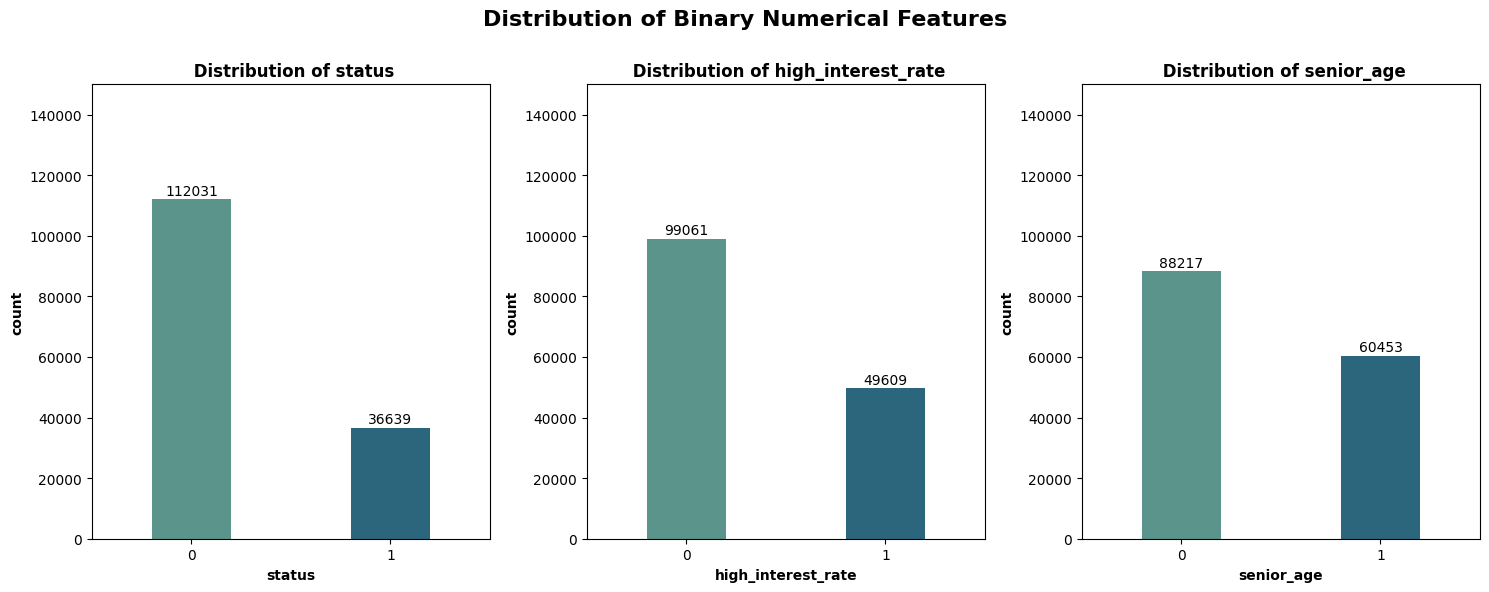

In [922]:
# the features 'status', 'high_interest_rate', 'senior_age' are binary features, cardinality is 2 here
# thus we need two check the distribution of the binary features
# plot the distribution of these features 

dist_feature_names = ["status", "high_interest_rate", "senior_age"]
df_binary_feature_dist = df_loan_numeric[dist_feature_names]


rows, cols = calc_subplot_grid(df_binary_feature_dist, 3)
fig, axes = plt.subplots(rows, cols, figsize=(rows * 15, cols * 2))
axes = axes.flatten()

for i, col in enumerate(df_binary_feature_dist.columns):
    sns.countplot(
        df_binary_feature_dist,
        x=col,
        palette="crest",
        hue=col,
        dodge=False,
        legend=False,
        ax=axes[i],
        width=0.4,
    )
    sns.set_palette("crest")
    axes[i].set_title(f" Distribution of {col}", fontweight="bold", fontsize=12)
    axes[i].margins(y=0.1)
    axes[i].set_xlabel(col, fontweight="bold")
    axes[i].set_ylabel("count", fontweight="bold")
    containers = axes[i].containers
    ax = axes[i]
    for container in containers:
        ax.bar_label(container, padding=1.0, fontsize=10)
        ax.set_ylim(0, 150000)

plt.suptitle(
    "Distribution of Binary Numerical Features",
    fontweight="bold",
    fontsize=16,
)
plt.tight_layout(rect=[0, 0, 1, 0.975])
fig_name = fig._suptitle.get_text()
save_fig(fig, fig_dir, fig_name, "svg", dpi=300)
#plt.close(fig)

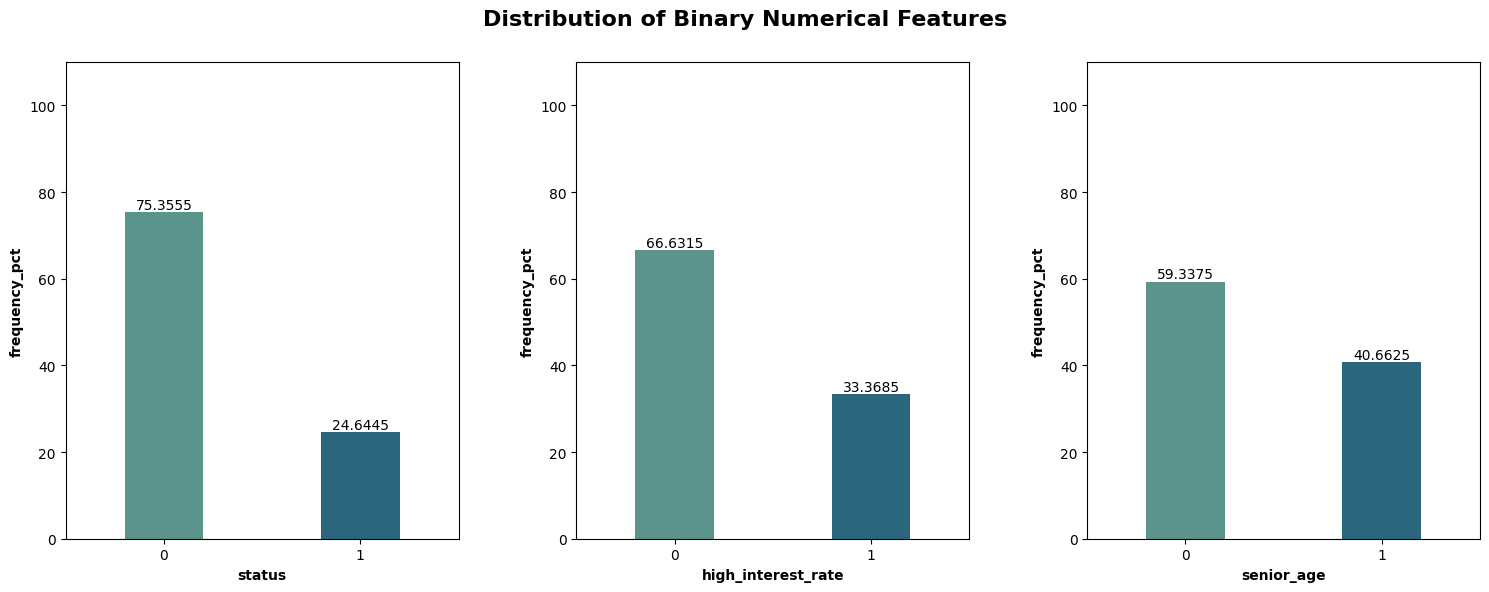

In [939]:
binary_feature_names = ["status", "high_interest_rate", "senior_age"]
df_binary_features = df_loan_numeric[binary_feature_names]


rows, cols = calc_subplot_grid(df_binary_features, 3)
fig, axes = plt.subplots(rows, cols, figsize=(rows * 15, cols * 2))
axes = axes.flatten()

for i, col in enumerate(df_binary_features.columns):
    # value_count(normalize=True) automatically excludes null values
    feature_dist = (
        df_binary_features[col]
        .value_counts(normalize=True)
        .mul(100)
        .reset_index()
        .set_axis([col, "frequency_pct"], axis=1)
    )
    ax = axes[i]
    sns.barplot(
        feature_dist,
        x=col,
        y=feature_dist.columns[1],
        palette="crest",
        hue=col,
        dodge=False,
        legend=False,
        ax=ax,
        width=0.4,
    )
    ax.set_ylim(0, 110)
    ax.set_ylabel(feature_dist.columns[1], fontweight="bold")
    ax.set_xlabel(col, fontweight="bold")



plt.suptitle("Distribution of Binary Numerical Features", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.975])
plt.subplots_adjust(wspace=0.3)
fig_name = fig._suptitle.get_text()
save_fig(fig, fig_dir, fig_name, "svg", dpi=300)

![](figures/eda/distribution_of_binary_numerical_features.svg)

In [837]:
## Conclusion
# staus '1' is very under represented
# high_interest_rate '1' is under represented
# senior_age is roughly balanced
# later we need to take this into consideration when doing the balancing


### 2.3.3 Multivariate analysis for numerical data

Applying correlation matrix and heatmap

In [838]:
# including target variable in correlation matrix is a standard
# helps to reveal potential predictor variables

# pandas corr() excludes null, NaN, NA for the calculation of correlation matrix
corr = round(df_loan_numeric.corr(), 2)
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    cmap="coolwarm",
    square=True,
    vmin=-1,
    vmax=1,
    center=0,
    annot_kws={"fontweight": "bold"},
    ax=ax
)
plt.suptitle(
    "Heatmap of Numerical Features in Loan Dataset",
    fontsize=16,
    fontweight="bold",
    x=0.6,
    ha="center",
)
plt.tight_layout(rect=[0, 0, 1, 0.975])
fig_name = fig._suptitle.get_text()
save_fig(fig, fig_dir, fig_name, "svg", dpi=300)
plt.close(fig)

![](figures/eda/heatmap_of_numerical_features_in_loan_dataset.svg)

## 2.4 Exploratory Data Analysis for categorical features

In [839]:
# select all the non-numerical features from the loan dataset
df_loan_cat = df_loan.select_dtypes(include="object")

### 2.4.1 Handle inconsistent labels/values

In [840]:
# replace '<25' label to '0-25' in age column to keep consistancy in naming
df_loan_cat.loc[df_loan_cat["age"] == "<25", "age"] = "0-25"
df_loan.loc[df_loan["age"] == "<25", "age"] = "0-25"

# fix inconsitent region names south -> South, central -> Central etc
df_loan_cat.loc[df_loan_cat["region"] == "central", "region"] = "Central"
df_loan_cat.loc[df_loan_cat["region"] == "south", "region"] = "South"
df_loan_cat.loc[df_loan_cat["security_type"] == "Indriect", "security_type"] = (
    "indirect"
)

### 2.4.2 Univariate analysis for categorical data

In [841]:
# null values by column
# df_loan.isnull().sum()

In [842]:
# calculate a gird for the subplots
rows, cols = calc_subplot_grid(df_loan_cat, 3)

# check variety of values in categorical data
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
axes = axes.flatten()

for i, col in enumerate(df_loan_cat.columns):
    sns.countplot(
        data=df_loan_cat,
        x=col,
        ax=axes[i],
        order=df_loan_cat[col].value_counts().index,
        width=0.4
    )
    sns.set_palette("crest")
    axes[i].set_title(f"Distribution of {col}", fontweight="bold", fontsize=12)
    axes[i].bar_label(axes[i].containers[0], padding=1.0, fontsize=10)
    axes[i].margins(y=0.1)
    axes[i].tick_params(axis="x", rotation=0)
    axes[i].set_xlabel(col, fontweight="bold")
    axes[i].set_ylabel("count", fontweight="bold")

fig.suptitle(
    "Variability & Frequency of Categorical Variables", fontweight="bold", fontsize=16
)
plt.tight_layout(rect=[0, 0, 1, 0.975])
plt.subplots_adjust(hspace=0.30)
fig_name = fig._suptitle.get_text()
save_fig(fig, fig_dir, fig_name, "svg", dpi=300)
plt.close(fig)


![](figures/eda/variability_&_frequency_of_categorical_variables.svg)

In [843]:
# Conclusion

# No high-cardinality features are detected / the variability of categorical features < 8 in every column
# (The value set is not much)
# Imbalanced categorical features

# - loan_limit
# - approv_in_adv
# - loan_type
# - credit_worthiness
# - open_credit
# - business_or_commercial
# - neg_ammortization
# - interest_only
# - lump_sum_payment
# - construction_type
# - occupancy_types
# - secured_by
# - total units
# - region
# - security_type

### 2.4.3 Multivariate analysis

Apply frequency table method to categorical features + target value

In [844]:
# parameters: pandas.crosstab(index, columns, values=None, rownames=None, colnames=None, aggfunc=None, margins=False, margins_name='All', dropna=True, normalize=False)

# frequency/ contingency table / two-way frequency table
def relative_frequency_table(data: pd.DataFrame, col: str, column: str):
    freq_table = pd.crosstab(index=data[col], columns=data[column], margins=True)
    rel_table = round(freq_table / freq_table.loc["All"], 3) * 100
    return rel_table


# make a special form of the frequency table to make it redy to plot on a groupped barchart
# applying melt() to transform the DataFrame
def melt_df_for_barplot(
    data: pd.DataFrame, id_feature: str, feature_name: str, new_value_name: str
):
    # loan_status_relfreq.index.name='status'
    data = data.iloc[:-1, :-1]
    df_melt = data.reset_index().melt(
        id_vars=id_feature, var_name=feature_name, value_name=new_value_name
    )
    return df_melt

In [845]:
target_var = "status"

In [846]:
rows, cols = calc_subplot_grid(df_loan_cat, 2)
fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * 13))
axes = axes.flatten()



for i, col in enumerate(df_loan_cat.columns):
    status_relfreq = relative_frequency_table(df_loan, target_var, col)
    df_melt = melt_df_for_barplot(
        status_relfreq,
        id_feature=target_var,
        feature_name=col,
        new_value_name="percentage",
    )
    ax = axes[i]

    sns.barplot(
        df_melt,
        x=col,
        y="percentage",
        hue=target_var,
        palette="crest",
        ax=ax,
        width=0.5,
    )
    ax.set_title(
        f"Relative frequency of target variable ' {target_var}' by {col}",
        fontweight="bold",
        fontsize=12,
    )
    ax.margins(y=0.1)
    ax.set_xlabel(col, fontweight="bold")
    ax.set_ylabel("percentage", fontweight="bold")
    ax.set_ylim(0, 115)

    # Real values from your melted DataFrame
    bar_labels = df_melt["percentage"].tolist()
    bars = ax.patches
    
    # Loop through only real bars, ignore ghost bars
    for bar, label in zip(bars, bar_labels):
        height = bar.get_height()
        if not pd.isna(height):
            ax.annotate(
                f"{height:.1f}%",
                (bar.get_x() + bar.get_width() / 2, height),
                ha="center",
                va="bottom",
                fontsize=10,
                fontweight="bold",
            )
# handles, labels = ax[0].get_legend_handles_labels()
# fig.legend(handles,labels,loc="lower center", ncol=len(labels), bbox_to_anchor=(0.5,-0.05))

hide_axes(axes, i)

# Each bar is a matplotlib.patches.Rectangle
# Retrieve them through ax.patches
# bar.get_height() # height of the current bar to write value on
# bar.get_x(): get the position of left edge of the bar
# bar.get_width(): get the with of the current bar
# to avoid plotting ghost bars with labels 0.0%, I need the 'percentages' by each variable from df_melt to keep real bars only

fig.suptitle(
    "Relation between Categorical Features and Target Variable",
    fontweight="bold",
    fontsize=16,
)
plt.tight_layout(rect=[0, 0, 1, 0.975])
plt.subplots_adjust(hspace=0.30)
fig_name = fig._suptitle.get_text()
save_fig(fig, fig_dir, fig_name, "svg", dpi=300)
plt.close(fig)

![](figures/eda/relation_between_categorical_features_and_target_variable.svg)

In [847]:
loan_status_relfreq = relative_frequency_table(df_loan, "status", "age")
melted_df = melt_df_for_barplot(loan_status_relfreq, "status", "age", "percentages")

## 2.5 Identifying Missing Value Mechanisms

### 2.5.1 Check the Patterns of Missingness

In [848]:
# Missingness Matrix: Row-by-row missingness map
fig, ax = plt.subplots(figsize=(15, 8))
msno.matrix(df_loan, sparkline=False, ax=ax)
plt.suptitle("Missingness Matrix  All Columns", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.975])
fig_name = fig._suptitle.get_text()
save_fig(fig, fig_dir, fig_name, "svg", dpi=300)
plt.close(fig)

![](figures/eda/missingness_matrix_all_columns.svg)

In [849]:
# Conclusion
# There is no consecutive missingness in the rows shared between multiple columns. There are fewer columns with high level missingness.
# 'interest_rate_spread' and 'upront_charges' behaves very similar, huge white blocks (missingnes) appear in the same rows
# 'ltv' and 'dtir1' behaves similar
# 'property_value' and 'ltv'  behaves similar

In [850]:
# missingness patterns are visually diluted => passing only columns which contain missing values => focused missingness pattern map
fig, ax = plt.subplots(figsize=(10, 10))
msno.matrix(df_loan[df_count_null_val["Features"].to_list()], ax=ax, sparkline=False)
plt.suptitle(
    "Missingness Matrix  Only Columns with NA", fontsize=16, fontweight="bold"
)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.975])
fig_name = fig._suptitle.get_text()
save_fig(fig, fig_dir, fig_name, "svg", dpi=300)
plt.close(fig)

![](figures/eda/missingness_matrix_only_columns_with_na.svg)

In [851]:
# The missingness is not significant in columns 'approv_in_adv', 'loan_purpose', 'term', 'neg_amortization', 'age', 'submission_of_application'
# let's compare only the columns with significant missingness within
fig, ax = plt.subplots(figsize=(10, 10))
msno.matrix(
    df_loan[
        [
            "interest_rate_spread",
            "upfront_charges",
            "dtir1",
            "property_value",
            "ltv",
            "income",
        ]
    ],
    ax=ax,
    sparkline=False,
)
plt.suptitle(
    "Missingness Matrix  Selected Columns with NA", fontsize=16, fontweight="bold"
)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.975])
fig_name = fig._suptitle.get_text()
save_fig(fig, fig_dir, fig_name, "svg", dpi=300)
plt.close(fig)

# Conclusion
# 'dtir1' 'poverty_value' 'ltv' sharing significant number of missing values among the same rows

![](figures/eda/missingness_matrix_selected_columns_with_na.svg)

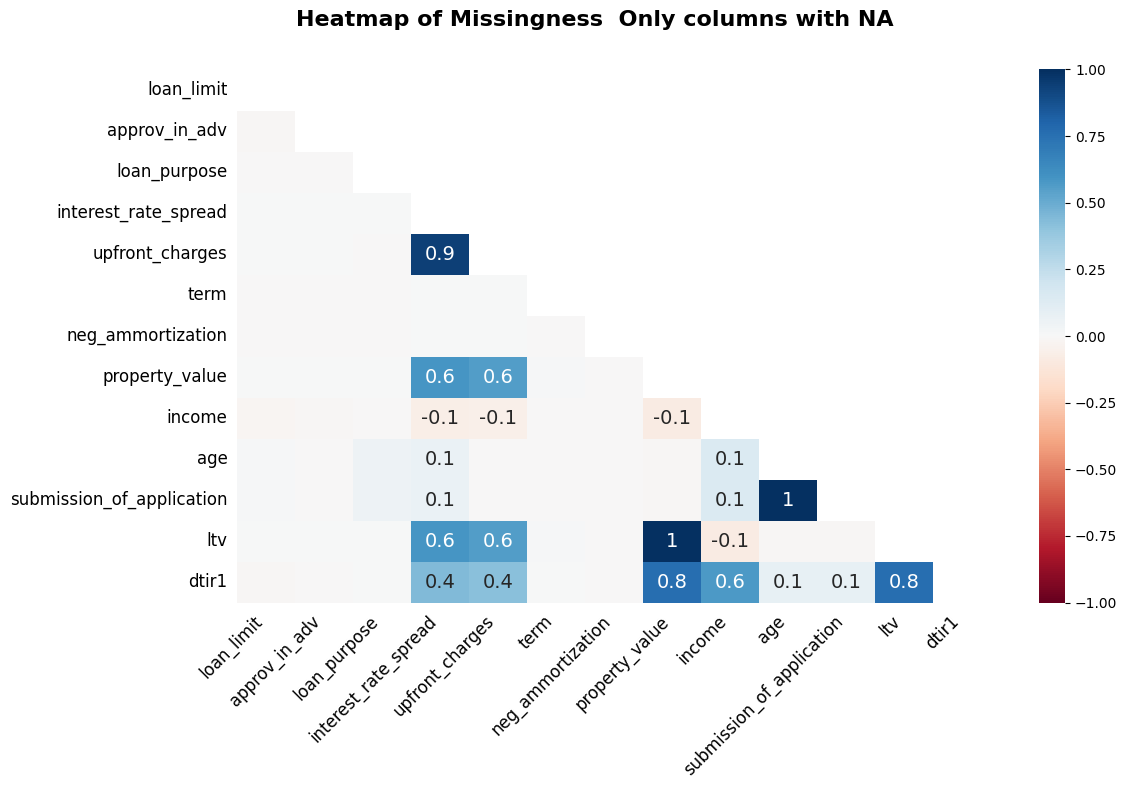

In [852]:
# Heatmap plots how missing values in different columns relate to each other => missingness correlation

fig, ax = plt.subplots(figsize=(12, 8))
msno.heatmap(df_loan, ax=ax)
plt.suptitle(
    "Heatmap of Missingness  Only columns with NA",
    fontsize="16",
    fontweight="bold"
)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.975])
fig_name = fig._suptitle.get_text()
save_fig(fig, fig_dir, fig_name, "svg", dpi=300)
#plt.close(fig)


![](figures/eda/heatmap_of_missingness_only_columns_with_na.svg)

In [853]:
# Conclusion:

# missingness strongly correlates between:
#  - 'ltv' and 'property_value' => they need same imputation method
#  - 'upfront_charges' and 'interest_rate_spread' => they need the same imputation
#  - 'age' and 'submission_of_application': identical shared missingness
#  - 'dtir1' 'property_value' and 'ltv':  dtir1 strongly linked to both ltv and property_value: missingness cascades

# features with low missingness correlation:
# - 'loan_limit', 'approv_in_adv', 'loan_purpose', 'term', 'neg_amortization', 'income'

### 2.5.2 Apply Missingness Indicator Variables
A missingness indicator is a new binary column that tells you whether a value in the original feature is missing or not.
Helps to explore the patterns of missingness.

In [854]:
#  function inserts a new column in to the official dataset if the checked column contains null value
# the new colum get a new name with 'missing_' tag which's rows contains only 1/0
# 1 = the value is missing
# 0 = the value is present


def create_missing_value_indicators(data: pd.DataFrame):
    df_mvi_data = data.copy()
    df_cols = df_mvi_data.columns
    for col in df_cols:
        if df_mvi_data[col].isna().sum() > 0:
            df_mvi_data["missing_" + col] = df_mvi_data[col].isna().astype(int)
    return df_mvi_data

In [855]:
df_mval_indicator = create_missing_value_indicators(df_loan)
rows = 7
cols = 2

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

i = 0
for col in df_mval_indicator.columns:
    if col.startswith("missing_"):
        ax = axes[i]
        sns.barplot(
            x=df_mval_indicator[col],
            y=df_mval_indicator[target_var],
            ax=ax,
            hue=df_mval_indicator[col],
            dodge=False,  # prevents groupped bars
            width=0.4,
            palette=["#3e7c82", "#6aa18e"],
            legend=False,  # use customized legend
        )

        # create new legend
        custom_legend = [
            mpatches.Patch(color="#3e7c82", label="Not Missing"),
            mpatches.Patch(color="#6aa18e", label="Missing"),
        ]
        ax.legend(
            handles=custom_legend,
            title=None,
            loc="lower center",
            bbox_to_anchor=(0.5, 1),
            ncol=3,
            frameon=False,
        )

        ax.set_ylim(0, 115)
        ax.set_xticks([0, 1])  # set position first
        ax.set_xticklabels(["0", "1"])
        ax.margins(y=0.10)
        ax.set_ylabel("approval ratio", fontweight="bold", fontsize=10)
        ax.set_xlabel(col, fontweight="bold", fontsize=10)

        bars = ax.patches
        for bar in bars:
            bar.set_height(bar.get_height() * 100)
            height = bar.get_height()
            if not pd.isna(height):
                ax.annotate(
                    f"{height:.1f}%",
                    (bar.get_x() + bar.get_width() / 2, height),
                    ha="center",
                    va="bottom",
                    fontsize=10,
                    fontweight="bold",
                )

        i = i + 1

hide_axes(axes,i-1)
fig.suptitle(
    "Correlation between Missingness in Features and Loan Approval",
    fontweight="bold",
    fontsize=16,
)
plt.tight_layout(rect=[0, 0, 1, 0.975], h_pad=8)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
fig_name = fig._suptitle.get_text()
save_fig(fig, fig_dir, fig_name, "svg", dpi=300)
plt.close(fig)

![](figures/eda/correlation_between_missingness_in_features_and_loan_approval.svg)

In [856]:
## Conclusion:

# Loan is significantly more likely to be approved in rows with missing values in feature

# - interest_rate_spread        (numerical)
# - upfront_charges             (numerical)
# - property_value              (numerical)
# - age                         (categorical)
# - submission_of_application   (categorical)
# - ltv                         (numerical)
# - dtir1                       (numerical)

# This excludes probability of MCAR.
# The missingness in these features (columns) have strong predictive power.

# 'age', 'submission_of_application', 'property_value', 'ltv' show extremely strong MAR behaviour.
#  When the data is missing the ratio of loan approval is 100% (probably policy-driven data collection process)

# 'interest_rate_spread', 'upfront_charges', 'dtir1' show strong MAR behaviour.
# These variables are only computed for loans that reached a certain stage in the approval workflow (it is consistent with a MAR mechanism)

# 'income' is the feature where the missingness is penalizing
#  It occurs due to not handed in documentation, informal employment, etc. => MAR behaviour

# As these features show strong dependency between missingness and loan approval => missingness indicators are highly predictive (valuable signal)
# => do imputation but keep missingness indicators for model building

# Safe-to-drop features
# 'loan limit, 'approv_in_adv', 'loan_purpose', 'term', 'neg_ammortization' due to weak missingness correlation + target dependence
# => row-wise deletion is unlikely to introduce substantial bias

# 3 Data Quality / Data Cleaning

## 3.1 Drop Rows and Cols with meaningless Missingness 

In [43]:
# Firstly remove unnecessary columns and rows based on the conclusion in EDA

# no valuable info for the model
df_loan.drop(columns=["Unnamed: 0", "id", "year"], axis=1, inplace=True)
df_mval_indicator.drop(columns=["Unnamed: 0", "id", "year"], axis=1, inplace=True)

# rows where null/missing value occurs in columns 'loan_limit, 'approv_in_adv', 'loan_purpose', 'term', 'neg_ammortization'
df_loan.drop(
    df_loan[
        df_loan["loan_limit"].isnull()
        | df_loan["approv_in_adv"].isnull()
        | df_loan["loan_purpose"].isnull()
        | df_loan["term"].isnull()
        | df_loan["neg_ammortization"].isnull()
    ].index,
    inplace=True,
)


### 3.2 Inspect Numerical Data Errors

In [44]:
print(df_loan_numeric.columns)

Index(['loan_amount', 'rate_of_interest', 'interest_rate_spread',
       'upfront_charges', 'term', 'property_value', 'income', 'credit_score',
       'ltv', 'status', 'dtir1', 'high_interest_rate', 'senior_age'],
      dtype='object')


In [45]:
# Function creates a file if the file yet does not exist given by the folder+filename
# Reminder: write another function where the output is JSON or XML to make the report compatible with monitoring tools


def write_to_txt(
    file_path: str,
    title: str | None = None,
    subtitle: str | None = None,
    content: str | None = None,
    new_line: bool = True,
):
    path = Path(file_path)
    # check parent directory exists
    path.parent.mkdir(parents=True, exist_ok=True)

    with path.open(mode="a", encoding="utf-8") as f:
        # add title if provided
        if title:
            f.write(title + "\n")
            f.write("=" * len(title) + "\n\n")

        # add subtitle if provided
        if subtitle:
            f.write(subtitle + "\n")
            f.write("-" * len(subtitle) + "\n")

        # add content if provided
        if content is not None:
            f.write(content)
            if new_line:
                f.write("\n")


In [46]:
# the range describes a plausible interval of values of the feature
# but the function returns the values that are out of the given range
def err_out_of_range_to_report(
    df: pd.DataFrame,
    feature: str,
    bounds: tuple[float | None, float | None],
    inclusive=False,
    use_abs=False,
):
    lower_bound, upper_bound = bounds
    s = df[feature]
    msg = f"    error count: {feature} "
    msg1 = ""
    msg2 = ""

    if use_abs:
        s = s.abs()
        msg = f"    error count: abs({feature}) "

    # non-inclusive
    if (lower_bound is not None) and (upper_bound is not None) and (inclusive is False):
        err_cnt_lwr_bnd = (s < lower_bound).sum()
        msg1 = msg + f"< {lower_bound}: {err_cnt_lwr_bnd}"

        err_cnt_uppr_bnd = (s > upper_bound).sum()
        msg2 = msg + f"> {upper_bound}: {err_cnt_uppr_bnd}"
        return [msg1, msg2]

    # inclusive
    if (lower_bound is not None) and (upper_bound is not None) and (inclusive is True):
        err_cnt_lwr_bnd = (s < lower_bound).sum()
        msg1 = msg + f"<= {lower_bound}: {err_cnt_lwr_bnd}"

        err_cnt_uppr_bnd = (s > upper_bound).sum()
        msg2 = msg + f">= {upper_bound}: {err_cnt_uppr_bnd}"
        return [msg1, msg2]

    # non-inclusive
    if (lower_bound is not None) and (inclusive is False):
        err_cnt_lwr_bnd = (s < lower_bound).sum()
        msg1 = msg + f"< {lower_bound}: {err_cnt_lwr_bnd}"
        return msg1, msg2

    # non-inclusive
    if (upper_bound is not None) and (inclusive is False):
        err_cnt_uppr_bnd = (s > upper_bound).sum()
        msg1 = msg + f"< {upper_bound}: {err_cnt_uppr_bnd}"
        return msg1, msg2

    # inclusive
    if (lower_bound is not None) and (inclusive):
        err_cnt_lwr_bnd = (s <= lower_bound).sum()
        msg1 = msg + f"< {lower_bound}: {err_cnt_lwr_bnd}"
        return msg1, msg2

    # inclusive
    if upper_bound is not None and (inclusive):
        err_cnt_uppr_bnd = (upper_bound <= s).sum()
        msg1 = msg + f"<= {upper_bound}: {err_cnt_uppr_bnd}"
        return msg1, msg2

    return [msg1, msg2]

In [48]:
v1, v2 = err_out_of_range_to_report(df_loan, "loan_amount", bounds=(10, 100))
print(v1)
print(v2)
print(
    err_out_of_range_to_report(
        df_loan, "rate_of_interest", bounds=(0, 1), inclusive=False
    )
)

    error count: loan_amount < 10: 0
    error count: loan_amount > 100: 144122
['    error count: rate_of_interest < 0: 35255', '    error count: rate_of_interest > 1: 108866']


In [49]:
# this function reports which numerical data points do not comply with the rules of fact/reality
def create_num_data_err_report(
    file_path: str,
    df: pd.DataFrame,
    feature: str,
    val_min_max=False,
    inclusive_range=False,
    bounds=tuple[float | None, float | None],
    use_abs=False,
    title: str | None = None,
    subtitle: str | None = None,
):
    content = "\n" + feature + ":"

    write_to_txt(
        file_path=file_path,
        title=title,
        subtitle=subtitle,
        content=content,
        new_line=True,
    )
    msg1, msg2 = err_out_of_range_to_report(
        df, feature, bounds, inclusive_range, use_abs
    )

    if len(msg1) > 0 and len(msg2) > 0:
        write_to_txt(file_path, content=str(msg1), new_line=True)
        write_to_txt(file_path, content=str(msg2), new_line=True)
    else:
        write_to_txt(file_path, content=str(msg1), new_line=True)

    if val_min_max is True:
        content = f"    maximum of {feature}: {df[feature].max()}"
        write_to_txt(file_path, content=content, new_line=True)

        content = f"    minimum of {feature}: {df[feature].min()}"
        write_to_txt(file_path, content=content, new_line=True)


In [50]:
# This function validates that a column contains integer-like values.
# Integers -> int
# Floats -> trimmed to int if the decimal is .0 like 360.0,  360.5 is rejected
# Alphanumeric / invalid -> NaN
# Logs unique invalid values to a text file if provided.
# Returns cleaned integer Series (nullable Int64).


def validate_numeric_column(
    data: pd.DataFrame, feature: str, file_path: str | None = None
):
    s = data[feature].astype("string")
    numeric = pd.to_numeric(s, errors="coerce")
    validated = pd.Series(pd.NA, index=s.index, dtype="Int64")

    is_numeric = numeric.notna()
    is_integer = is_numeric & (numeric % 1 == 0)
    non_integer_mask = is_numeric & (numeric != 0)

    validated[is_integer] = numeric[is_integer].astype("Int64")

    # Report non-integer floats
    if file_path and non_integer_mask.any():
        unique_invalid_values = numeric[non_integer_mask].unique()
        write_to_txt(
            file_path=file_path,
            subtitle="Float64 data validation for",
            content=feature,
            new_line=True,
        )
        for val in unique_invalid_values:
            write_to_txt(file_path, content=str(val))

    data[feature] = validated[is_integer]

In [51]:
# I have to check whether the values are logically/physically implausible/plausible in their context e.g. income can not be negative
# rules are needed to decide what matters realistic/unrealistic data
# Flag implausibe values to 'NaN'

path = "reports/loan_dataset_data_quality_report.txt"
title = "Loan Dataset – Data Quality Report"
subtitle = " Numerical Data Errors"


# 1. 'loan_amount'
# - can not be negative or zero
create_num_data_err_report(
    path,
    df_loan,
    "loan_amount",
    val_min_max=True,
    inclusive_range=False,
    bounds=(0, None),
    use_abs=False,
    title=title,
    subtitle=subtitle,
)

# 2. 'rate_of_interest'
# - can not be negative
# - can not be unrealistically large like 200%
# - upper sanity bound is needed
create_num_data_err_report(
    path,
    df_loan,
    "rate_of_interest",
    val_min_max=True,
    inclusive_range=True,
    bounds=(0, 200),
    use_abs=False,
)


# 3. 'interest_rate_spread'
# - can be negative in practice, if the loan priced below benchmark
# - can not be unrealistically high like 200%
# - upper sanity bound is needed + (absolute value check)
create_num_data_err_report(
    path,
    df_loan,
    "interest_rate_spread",
    val_min_max=True,
    inclusive_range=True,
    bounds=(None, 200),
    use_abs=True,
)


# 4. 'term'
# - can not be negative or zero
# - has to be integer, but according to pandas dtype is float64 so I have to validate it
# - non-standard values e.g. 7 months are suspicious, but retained (short-term loans)
create_num_data_err_report(
    path,
    df_loan,
    "term",
    val_min_max=True,
    inclusive_range=True,
    bounds=(12, 360),
    use_abs=False,
)


# 5. 'property_value'
# - can not be negative or zero
create_num_data_err_report(
    path,
    df_loan,
    "property_value",
    val_min_max=True,
    inclusive_range=False,
    bounds=(0, None),
    use_abs=False,
)

# 6. 'income'
# - can not be negative (can be zero like unemployed/ retirees)
# - if income is 0, then check the frequency, and flag
# - lower sanity bound is needed
create_num_data_err_report(
    path,
    df_loan,
    "income",
    val_min_max=True,
    inclusive_range=True,
    bounds=(0, None),
    use_abs=False,
)


# 7. 'credit_score'
# - difficult to define the rules without knowing in-house banking system
# - has to be [0, 200] or credit_score > 900
create_num_data_err_report(
    path,
    df_loan,
    "credit_score",
    val_min_max=True,
    inclusive_range=True,
    bounds=(200, 900),
    use_abs=False,
)


# 8. 'ltv' Loan To Value
# - can not be negative or zero
# - extra: it's represented as % in tha dataset, so it must be greater than 1
# - rarely unrealistically high like 300%, sanity bound is needed, flag implausible values as NaN
create_num_data_err_report(
    path,
    df_loan,
    "ltv",
    val_min_max=True,
    inclusive_range=True,
    bounds=(1, 300),
    use_abs=False,
)


# 9. 'status'
# - has to be 1 or 0, but it is right as I examined the variability of it in EDA
# - no missing value examined in EDA
create_num_data_err_report(
    path,
    df_loan,
    "status",
    val_min_max=True,
    inclusive_range=True,
    bounds=(0, 1),
    use_abs=False,
)

# 10. 'dtir1'
# - can not be negative
# - zero menas no debt
# - can not be negative or zero, but it has to be [1, 100] as the value is expressed in percentage
create_num_data_err_report(
    path, df_loan, "dtir1", inclusive_range=True, bounds=(1, 100), use_abs=False
)


# 11. 'high_interest_rate'
# - has to be 1 or 0, but it is right as I examined the variability of it in EDA
# - no missing value examined in EDA
create_num_data_err_report(
    path,
    df_loan,
    "high_interest_rate",
    val_min_max=True,
    inclusive_range=True,
    bounds=(0, 1),
    use_abs=False,
)

# 12. 'senior_age'
# - has to be 1 or 0, but it is right as I examined the variability of it in EDA
# - no missing value examined in EDA
create_num_data_err_report(
    path,
    df_loan,
    "senior_age",
    val_min_max=True,
    inclusive_range=True,
    bounds=(0, 1),
    use_abs=False,
)


In [104]:
# validate feature 'term'
validate_numeric_column(df_loan, "term", path)

In [92]:
df_income = df_loan["income"].value_counts().reset_index().sort_values(by="income")


with open("reports/income_frequency_report.txt", mode="w", encoding="utf-8") as f:
    f.write(df_income.to_string(max_rows=None, index=False))
    f.close()

3120.0
